In [1]:
import pandas as pd
from src.utils import MySQLAgent, OracleAgent
# from src.plot_tools import cat_value_count_bar_plot, num_value_count_bar_plot
import json
from datetime import datetime

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

### Helper functions

In [2]:
def cat_value_count_bar_plot(df, column, color, title, xlabel, y_label):
    # Calculate the distribution of 'is_improve'
    distribution = df[column].value_counts()

    # Create a bar plot
    plt.figure(figsize=(6, 4))
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()


In [3]:
def num_value_count_bar_plot(df, column, color, title, xlabel, ylabel):
    df[column] = df[column].astype('int')
    distribution = df[column].sort_values().value_counts(sort=False)  # Sort the values by index

    # Create a bar plot
    plt.figure(figsize=(6, 4))  # Adjust figure size as needed
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()

In [4]:
def read_config(path):
    try:
        with open(path, 'r') as file:
            configs = json.load(file)

        return configs
    except FileNotFoundError:
        print(f"The file {path} was not found.")
    except json.JSONDecodeError:
        print(f"Error decoding JSON from the file {path}.")

In [5]:
configs = read_config(path="./conn/connections.json")
job_configs = configs["CREDITREPORT"]['VM1_mysql_conn_info']
sql_agent = MySQLAgent(job_configs)

In [6]:
query = """
    select * from company
"""
df_company = sql_agent.read_table(query=query)
df_company.head()

,business_accounting_no,company_name,internal_id,query_name
0,00700019,國昌綜合工廠有限公司,K7913,None
1,00713181,華聯食品工業股份有限公司,J5984,None
2,00784930,建寶食品股份有限公司,K4395,None
3,00966299,財團法人台北市瑠公農業產銷基金會,K9232,None
4,01055919,新光醫療財團法人,K1282,None


In [7]:
i = 0
# company = df_company.iloc[i]
company = df_company[df_company['business_accounting_no'] == '27450696']
company_account = company.business_accounting_no.values[0]
company_name = company.company_name.values[0]
internal_id = company.internal_id.values[0]
company_account

'27450696'

In [8]:
company

,business_accounting_no,company_name,internal_id,query_name
3454,27450696,日月千禧酒店股份有限公司,K3844,None


#### companyinfo01

- 企業狀態
- 地址關聯
- 資本額(Captial_Stock_Amount)
- 最近更新日期

In [9]:
try:
    query = f"""
        select * from companyinfo01
        where Business_Accounting_No = {company_account}
    """
    companyinfo01 = sql_agent.read_table(query=query)
    companyinfo01.head()
except Exception as e:
    print("An error occurred:", e)


In [10]:
companyinfo01

,business_accounting_no,company_status_desc,company_name,capital_stock_amount,paid_in_capital_amount,responsible_name,company_location,register_organization_desc,company_setup_date,change_of_approval_data,revoke_app_date,case_status,case_status_desc,sus_app_date,sus_beg_date,sus_end_date,createtime,updatetime
0,27450696,核准設立,日月千禧酒店股份有限公司,800000000,700000000,張重興,臺中市西屯區市政路77號,經濟部商業司,0930923,1110428,,,,,,,2024-01-29 06:57:38,2024-03-08 20:02:34


In [11]:
# 公司狀態
company_status = companyinfo01['company_status_desc'].values[0]

# 地址關聯 - neo4j

# 資本額
company_captial = companyinfo01['capital_stock_amount'].values[0]

#### EPA

In [12]:
query = f"""
select * from epa_ems_p_46
where Business_Accounting_No = {company_account}
"""
df_epa = sql_agent.read_table(query=query)
df_epa.columns = df_epa.columns.str.lower()
df_epa.head()

,business_accounting_no,ems_no,fac_name,county_name,document_no,transgress_date,transgress_law,penalty_money,penalty_date,ispetition,...,is_improve,inspection_datetime_s,penaltykind,isimportant,paymentstate,isreminder,isadmincourt,isreducemoney,createtime,updatetime
0,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-101-110001,2012-08-28,環境影響評估法第17條,300000,2012-11-16,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
1,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-107-010001,2017-11-10,環境影響評估法第17條,300000,2018-01-02,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
2,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-060013,2013-05-14,空氣污染防制法第20條第1款,100000,2013-06-17,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
3,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-110014,2013-09-16,空氣污染防制法第20條第1項,200000,2013-11-11,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
4,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,41-101-100702,2012-08-15,廢棄物清理法第27條第2款,4500,2012-10-11,0,...,已改善完成,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17


In [13]:
if df_epa.size == 0:
    print(f'{company_name} 沒有環保署裁處紀錄。')

In [14]:
df_epa[['document_no', 'is_improve']]

,document_no,is_improve
0,10-101-110001,不須改善
1,10-107-010001,不須改善
2,20-102-060013,已改善完成
3,20-102-110014,已改善完成
4,41-101-100702,已改善完成


In [15]:
df_epa.sort_values('penalty_date', ascending=True)

,business_accounting_no,ems_no,fac_name,county_name,document_no,transgress_date,transgress_law,penalty_money,penalty_date,ispetition,...,is_improve,inspection_datetime_s,penaltykind,isimportant,paymentstate,isreminder,isadmincourt,isreducemoney,createtime,updatetime
4,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,41-101-100702,2012-08-15,廢棄物清理法第27條第2款,4500,2012-10-11,0,...,已改善完成,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
0,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-101-110001,2012-08-28,環境影響評估法第17條,300000,2012-11-16,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
2,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-060013,2013-05-14,空氣污染防制法第20條第1款,100000,2013-06-17,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
3,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,20-102-110014,2013-09-16,空氣污染防制法第20條第1項,200000,2013-11-11,0,...,已改善完成,,限期改善,,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17
1,27450696,B23A9786,日月千禧酒店股份有限公司,臺中市,10-107-010001,2017-11-10,環境影響評估法第17條,300000,2018-01-02,0,...,不須改善,,罰鍰(非連續處罰),,無分期已繳清,否,否,,2024-01-29 14:32:28,2024-03-08 13:27:17


In [16]:
# 共有幾筆紀錄
row_count = df_epa.shape[0]

# 最高裁處金額
max_penalty_money = df_epa['penalty_money'].max()

# 近期裁處金額
df_epa['penalty_date'] = pd.to_datetime(df_epa['penalty_date'])
latest_penalty_money = df_epa.loc[df_epa['penalty_date'] == df_epa['penalty_date'].max(), 'penalty_money'].values[0]


In [17]:
# is_improve分布
# cat_value_count_bar_plot(df_epa, 'is_improve', 'skyblue', '環保署裁處後的改善情況', '改善情況類別', '次數')

In [18]:
# penaltykind分布
# cat_value_count_bar_plot(df_epa, 'penaltykind', 'skyblue', '環保署裁處類別分布', '裁處類別', '次數')

In [19]:
# 裁處金額分布
# num_value_count_bar_plot(df_epa, 'penalty_money', 'skyblue', '環保署裁處金額分布', '裁處金額', '次數')

### PST

In [20]:
configs = read_config(path="./conn/connections.json")
job_configs = configs["CREDITREPORT"]['BIDB_conn_info']
oracle_agent = OracleAgent(job_configs)

In [21]:
query = f"""
select * from ODS.w_yfy_crd_pst_f

"""
# where debtor_accounting_no = '{company_account}'
df_pst = oracle_agent.read_table(query=query)
df_pst['agreement_end_date'] = pd.to_datetime(df_pst['agreement_end_date'])
df_pst.head()

,register_organization_desc,register_no,change_no,annulment_no,secured_type,register_date,change_date,annyulment_date,debtor_title,debtor_accounting_no,...,agreement_end_date,agreement_amount,property_count,is_floating_lien,creation_dt,update_dt,datasource_num_id,other_memo,currency,datatype
0,交通部公路總局,30-112-424-1(22237),None,None,動產抵押,2023/08/17,None,None,玠積國際有限公司,59229348,...,2033-07-26,960000.0,1.0,否,2023/09/15,2023/09/15,19518,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：交通部公路總局02-23070123,新台幣,公示案件
1,交通部公路總局,30-108-424-1(12703),None,None,附條件買賣,2019/06/14,None,None,玠積國際有限公司,59229348,...,2024-08-31,1303620.0,1.0,否,2023/09/15,2023/09/15,19519,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：交通部公路總局02-23070123,新台幣,公示案件
2,交通部公路總局,64-112-424-1(02393),None,None,動產抵押,2023/01/19,None,None,新奇化工工業社,59239275,...,2038-01-18,1160000.0,1.0,否,2023/09/15,2023/09/15,19522,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：交通部公路總局02-23070123,新台幣,公示案件
3,高雄市政府經濟發展局,高市經發工動字第10548號,None,None,動產抵押,2022/12/30,None,None,莊記綠豆鑽食品有限公司,59241856,...,2052-12-01,7200000.0,1.0,否,2023/09/15,2023/09/15,19523,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：高雄市政府經濟發展局07-3368333...,新台幣,公示案件
4,高雄市政府經濟發展局,高市經發工動字第8136號,None,None,動產抵押,2020/07/17,None,None,廣泰利食品有限公司,59244798,...,2049-12-31,3600000.0,1.0,否,2023/09/15,2023/09/15,19524,註：如需標的物明細請至各登記機關辦理抄錄。登記機關：高雄市政府經濟發展局07-3368333...,新台幣,公示案件


In [22]:
df_pst.secured_type.value_counts()

secured_type
無動產抵押資料    19154
動產抵押        4430
附條件買賣        596
Name: count, dtype: int64

In [23]:
df_pst.currency.value_counts()

currency
新台幣    4965
日圓        8
美金        6
Name: count, dtype: int64

In [24]:
df1 = df_pst[df_pst['secured_type'] == '動產抵押']
df1.columns

Index(['register_organization_desc', 'register_no', 'change_no',
       'annulment_no', 'secured_type', 'register_date', 'change_date',
       'annyulment_date', 'debtor_title', 'debtor_accounting_no',
       'debtor_substitute_title', 'debtor_substitute_acct_no',
       'creditor_title', 'creditor_accounting_no', 'creditor_substitute_title',
       'creditor_substitute_acct_no', 'agreement_start_date',
       'object_owner_desc', 'object_owner_accounting_no', 'object_location',
       'is_max_limit', 'object_type', 'agreement_end_date', 'agreement_amount',
       'property_count', 'is_floating_lien', 'creation_dt', 'update_dt',
       'datasource_num_id', 'other_memo', 'currency', 'datatype'],
      dtype='object')

In [25]:
# ? is_floating_lien

df1[['debtor_title', 'debtor_accounting_no',
       'creditor_title', 'creditor_accounting_no', 'creditor_substitute_title',
        'object_location','is_max_limit', 'object_type', 'agreement_end_date', 'agreement_amount',
       'property_count', 'creation_dt', 'update_dt',
        'currency', 'datatype']].head()

,debtor_title,debtor_accounting_no,creditor_title,creditor_accounting_no,creditor_substitute_title,object_location,is_max_limit,object_type,agreement_end_date,agreement_amount,property_count,creation_dt,update_dt,currency,datatype
0,玠積國際有限公司,59229348,瑞興商業銀行股份有限公司,28417921,李彥蒲,811-高雄市楠梓區加仁路１２１號一、二、三樓,None,1、汽車、大型重型機器腳踏車及拖車,2033-07-26,960000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件
2,新奇化工工業社,59239275,和潤企業股份有限公司,16844548,陳沛汝,502-彰化縣芬園鄉溪頭村彰南路一段１０３巷４４號,None,1、汽車、大型重型機器腳踏車及拖車,2038-01-18,1160000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件
3,莊記綠豆鑽食品有限公司,59241856,中租迪和股份有限公司,05072925,None,高雄市鳳山區鳳仁路97-71號,是,1、機器設備或工具,2052-12-01,7200000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件
4,廣泰利食品有限公司,59244798,中租迪和股份有限公司,05072925,None,高雄市鳳山區鎮北里鳳仁路93-51號,是,1、機器設備或工具,2049-12-31,3600000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件
14,廣泰利食品有限公司,59244798,合作金庫商業銀行股份有限公司,70799128,None,高雄市鳳山區鳳仁路93-51號,是,1、機器設備或工具,2040-04-23,1920000.0,1.0,2023/09/15,2023/09/15,新台幣,公示案件


Pst in past

In [26]:
df_pst_past = df1[df1['agreement_end_date'] <= datetime.now()]

In [27]:
# total agreement_amount
total_agreement = df_pst_past.agreement_amount.sum().astype('int64')

# the nearest end_date
nearest_end_date = df_pst_past['agreement_end_date'].max()

# the nearest agreement_amount
nearest_agreement_amount = df_pst_past.loc[df_pst_past['agreement_end_date'] == df_pst_past['agreement_end_date'].max(), 'agreement_amount'].values[0].astype('int64')
nearest_agreement_amount

# 

# detail data?

5600000

In [28]:
def cat_value_count_bar_plot(df, column, color, title, xlabel, y_label):
    # Calculate the distribution of 'is_improve'
    distribution = df[column].value_counts()

    # Create a bar plot
    plt.figure(figsize=(6, 4))
    bars = distribution.plot(kind='bar', color=color)

    # Add annotations to each bar
    for i, count in enumerate(distribution):
        plt.text(i, count + 0.1, str(count), ha='center')


    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()

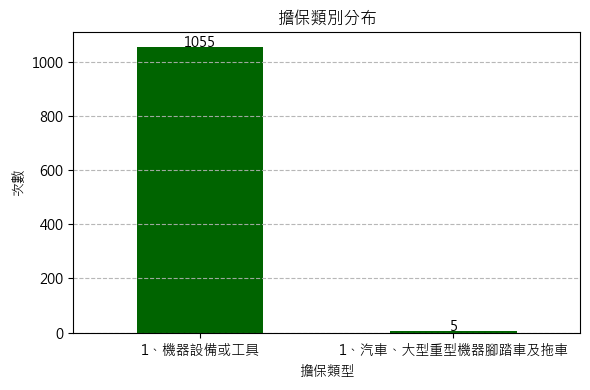

In [29]:
# object_type distribution
cat_value_count_bar_plot(df_pst_past, 'object_type', 'darkgreen', '擔保類別分布', '擔保類型', '次數')

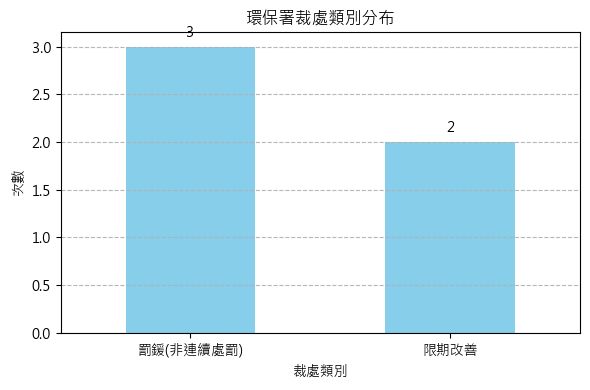

In [30]:
# cat_value_count_bar_plot(df_epa, 'penaltykind', 'skyblue', '環保署裁處類別分布', '裁處類別', '次數')

Pst in future

In [31]:
df_pst_future = df1[df1['agreement_end_date'] > datetime.now()]

### Judgement